# Load Modules

In [18]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

# Load Data

In [20]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [21]:
feat_to_use = info_col + phot_flux + phot_flux_hilim + phot_flux_lolim + en_flux + en_flux_hilim + en_flux_lolim + powlaw_fit +bb_fit +hard+ intra_obs_var +inter_ob_var 
data_cv = pd.read_csv('filtered_data/cv_old_data.csv' , index_col='obs_id')[feat_to_use]
data_cv.insert(0 , 'class' , ['CV']*len(data_cv))
data_pl  =  pd.read_csv('filtered_data/pl_old_data.csv' , index_col = 'obs_id')[feat_to_use]
data_pl.insert(0 , 'class' , ['PL']*len(data_pl))
data_lx  =  pd.read_csv('filtered_data/lmxb_data.csv' , index_col = 'obs_id')[feat_to_use]
data_lx.insert(0 , 'class' , ['LX']*len(data_lx))

In [22]:
# sns.histplot(data_cv['num_obs'] , color='black' , alpha = 0.3)
# sns.histplot(data_pl['num_obs'] , color='crimson' ,  alpha = 0.3)
# sns.histplot(data_lx['num_obs'] , color = 'blue' ,  alpha = 0.3)
# plt.show()

In [23]:
data = pd.concat([data_cv , data_pl , data_lx] , axis=0)
data

,class,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3974.2,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LX,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_90_obs_0,LX,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_91_obs_0,LX,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,8.934000e-09,5.0,0.8,1.257000e-07,NaN,0.247,5.992000e-09,NaN,NaN,NaN


In [24]:
data.dropna(axis=0)

,class,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_26_obs_8,CV,CV_26,13,CXOGLB_J002403.7-720423,2CXO J002403.7-720423,6.015750,-72.07306,68771.4,16.15,6262.243,...,0.000001,6.0,1.0,7.390000e-07,6.0,1.0,0.000003,5.0,0.92,0.000001
CV_28_obs_1,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,31673.8,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054
CV_28_obs_3,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,31673.8,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054
CV_28_obs_5,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,65237.5,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054
CV_28_obs_6,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,59044.6,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054
CV_28_obs_7,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,65240.7,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054
CV_28_obs_8,CV,CV_28,13,CXOGLB_J002406.3-720443,2CXO J002406.4-720443,6.026676,-72.07863,68771.4,53.28,18692.220,...,0.000002,8.0,1.0,1.935000e-06,8.0,1.0,0.000013,8.0,1.00,0.000054


# Remove sparse columns

In [25]:
sp = [] 
for f in feat_to_use:
    #print(f)
    na = data[feat_to_use][f].isna().value_counts()
    try:
        sp.append(float(1-na[0]/(na[0]+na[1])))
    except:
        sp.append(0)
sp =  np.asarray(sp)
sparsity = pd.DataFrame(
    {
        "feat" : feat_to_use ,
        "sp_val" :sp
    }
).sort_values(by='sp_val' , ascending=False).reset_index(drop=True)
sparsity

,feat,sp_val
0,var_index_u,0.953091
1,var_index_s,0.878587
2,var_index_h,0.876380
3,kp_prob_u,0.871413
4,ks_prob_u,0.870861
...,...,...
101,ra,0.000000
102,num_obs,0.000000
103,name,0.000000
104,src_n,0.000000


In [26]:
sparse_feat = sparsity[sparsity['sp_val']>0.5].sort_values(by='sp_val').reset_index(drop=True)
sparse_feat = sparse_feat['feat'].to_list()
#sparse_feat

In [27]:
dense_feat = sparsity[sparsity['sp_val']<0.2].sort_values(by='sp_val').reset_index(drop=True)
dense_feat = dense_feat['feat'].to_list()
#dense_feat

In [28]:
data_use = data[dense_feat+['class']]
details(data , 'Before removing sparse columns')
details(data_use , 'After removing sparse columns')

Before removing sparse columns
________________________________________________
Sparsity in the data : 0.44
Data shape (1812, 107)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521
After removing sparse columns
________________________________________________
Sparsity in the data : 0.01
Data shape (1812, 22)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


## Take log

In [29]:
flux_feat = phot_flux + phot_flux_lolim + phot_flux_hilim + en_flux + en_flux_lolim + en_flux_hilim
flux_feat_avail = list(set(flux_feat) & set(dense_feat))
def take_log(data_sent):
    x_train_log = data_sent.copy()
    for f in flux_feat_avail[:]:
        x_train_log.loc[:,f] = -(np.log10(x_train_log.loc[:,f]))
    x_train_log = x_train_log.replace(-np.inf , np.nan)
    x_train_log = x_train_log.replace(np.inf , np.nan)
    return x_train_log


## Imputation

In [30]:
df_log = take_log(data_use)
df_log

,src_id,name,num_obs,ra,likelihood,significance,dec,livetime,src_n,photflux_aper_hilim_b,...,photflux_aper_hilim_s,photflux_aper_hilim_m,hard_hs,hard_hm,flux_aper_hilim_s,hard_ms,flux_aper_hilim_h,flux_aper_hilim_m,photflux_aper_hilim_u,class
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,2CXO J004245.0+411520,33,10.68773,304.46460,11.31,41.255820,4903.5,[HPH2013]_176__________,NaN,...,6.109803,6.322119,-0.9994,0.9994,14.861697,-0.9994,14.231288,14.898597,4.583359,CV
CV_0_obs_1,CV_0,2CXO J004245.0+411520,33,10.68773,304.46460,11.31,41.255820,3974.2,[HPH2013]_176__________,5.909742,...,5.768785,NaN,-0.9994,NaN,14.634699,NaN,14.212256,NaN,3.683610,CV
CV_0_obs_2,CV_0,2CXO J004245.0+411520,33,10.68773,304.46460,11.31,41.255820,3907.5,[HPH2013]_176__________,5.705754,...,5.507379,6.132415,-0.9994,0.9994,14.244201,-0.9994,14.144663,14.723538,3.716247,CV
CV_0_obs_3,CV_0,2CXO J004245.0+411520,33,10.68773,304.46460,11.31,41.255820,3907.5,[HPH2013]_176__________,5.847100,...,5.826231,6.102483,-0.9994,0.9994,14.692290,-0.9994,14.076083,14.693575,3.726999,CV
CV_0_obs_4,CV_0,2CXO J004245.0+411520,33,10.68773,304.46460,11.31,41.255820,3907.5,[HPH2013]_176__________,5.394264,...,5.830914,5.903090,0.4247,0.9994,14.696588,-0.9994,13.904134,14.475734,3.771600,CV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,2CXO J181044.4-260901,1,272.68530,512.97550,9.29,-26.150370,31871.5,SAX_J1810.8-2609_____,4.904831,...,5.280835,5.614394,-0.5547,-0.2124,14.131414,-0.3848,14.060930,14.276052,5.618524,LX
LMXB_90_obs_0,LMXB_90,2CXO J212314.5-054753,1,320.81060,132.76700,4.06,-5.798128,17705.1,XTE_J2123-058________,5.360115,...,5.630970,6.273844,-0.5609,0.2711,14.392867,-0.7008,14.403843,14.867740,5.444180,LX
LMXB_91_obs_0,LMXB_91,2CXO J173547.0-302858,1,263.94590,114.24570,4.89,-30.482820,18855.8,XB_1732-304__________,5.235226,...,6.232770,5.553152,0.2311,-0.6034,15.057545,0.7295,14.464833,14.170118,6.055073,LX


# Source-wise imputation

In [33]:
info_col_cl = info_col+['class']
src_list = np.unique(df_log['src_id'])
df_all_imp = pd.DataFrame()
for s in tqdm(src_list[:]):
    print('----------------------------------')
    print(s)
    temp = df_log[df_log['src_id']==s]
    temp_val = temp.drop(columns=info_col_cl)
    temp_id = temp[info_col_cl]
    rf_imputer = MissForest(verbose=0 , decreasing=True)
    #new_data = d.drop(columns= ['class'])
    try:
        new_data = rf_imputer.fit_transform(temp_val)
        imp_data =  pd.DataFrame(new_data , columns = temp_val.columns.to_list()  , index=temp_val.index.to_list())
        imp_data.index.name = 'obs_id'
    except:
        print('all col missing')
        imp_data = temp_val
    temp_imp = pd.concat([temp_id , imp_data] , axis = 1)
    df_all_imp = df_all_imp.append(temp_imp)
    #display(temp)
    #display(temp_val)
display(df_all_imp)

  0%|          | 0/210 [00:00<?, ?it/s]

----------------------------------
CV_0
all col missing
----------------------------------
CV_1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


  1%|          | 2/210 [00:13<23:15,  6.71s/it]

Iteration: 6
----------------------------------
CV_10
all col missing
----------------------------------
CV_11
all col missing
----------------------------------
CV_12
all col missing
----------------------------------
CV_13
all col missing
----------------------------------
CV_14
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


  3%|▎         | 7/210 [00:55<27:10,  8.03s/it]

Iteration: 4
----------------------------------
CV_15
all col missing
----------------------------------
CV_16
all col missing
----------------------------------
CV_17
all col missing
----------------------------------
CV_18
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


  5%|▌         | 11/210 [01:49<35:18, 10.65s/it]

Iteration: 6
----------------------------------
CV_19
Iteration: 0
Iteration: 1


  6%|▌         | 12/210 [02:04<37:12, 11.28s/it]

Iteration: 2
----------------------------------
CV_2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


  6%|▌         | 13/210 [03:20<1:13:10, 22.29s/it]

Iteration: 6
----------------------------------
CV_20
all col missing
----------------------------------
CV_21
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


  7%|▋         | 15/210 [03:58<1:09:03, 21.25s/it]

Iteration: 4
----------------------------------
CV_22
all col missing
----------------------------------
CV_23
all col missing
----------------------------------
CV_24
all col missing
----------------------------------
CV_26
Iteration: 0
Iteration: 1
Iteration: 2


  9%|▉         | 19/210 [04:33<48:23, 15.20s/it]  

Iteration: 3
----------------------------------
CV_27
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 10%|▉         | 20/210 [04:40<44:15, 13.98s/it]

Iteration: 4
----------------------------------
CV_28
Iteration: 0


 10%|█         | 21/210 [04:56<44:48, 14.22s/it]

Iteration: 1
----------------------------------
CV_29
Iteration: 0
Iteration: 1
Iteration: 2


 10%|█         | 22/210 [05:25<54:03, 17.25s/it]

Iteration: 3
----------------------------------
CV_3
Iteration: 0
Iteration: 1


 11%|█         | 23/210 [05:27<43:21, 13.91s/it]

Iteration: 2
----------------------------------
CV_30
Iteration: 0
Iteration: 1
Iteration: 2


 11%|█▏        | 24/210 [05:51<50:38, 16.33s/it]

Iteration: 3
----------------------------------
CV_31
all col missing
----------------------------------
CV_32
Iteration: 0


 12%|█▏        | 26/210 [05:52<30:03,  9.80s/it]

Iteration: 1
----------------------------------
CV_33
Iteration: 0
Iteration: 1


 13%|█▎        | 27/210 [06:06<33:13, 10.89s/it]

Iteration: 2
----------------------------------
CV_34
all col missing
----------------------------------
CV_35
all col missing
----------------------------------
CV_36
all col missing
----------------------------------
CV_37
all col missing
----------------------------------
CV_38
all col missing
----------------------------------
CV_4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


 16%|█▌        | 33/210 [07:12<32:04, 10.87s/it]

Iteration: 7
----------------------------------
CV_40
all col missing
----------------------------------
CV_41
all col missing
----------------------------------
CV_42
Iteration: 0
Iteration: 1


 17%|█▋        | 36/210 [07:18<23:28,  8.09s/it]

Iteration: 2
----------------------------------
CV_43
all col missing
----------------------------------
CV_44
all col missing
----------------------------------
CV_45
----------------------------------
CV_48
all col missing
----------------------------------
CV_49


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 20%|█▉        | 41/210 [07:21<13:32,  4.81s/it]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 23%|██▎       | 49/210 [07:21<06:30,  2.42s/it]

Iteration: 2
----------------------------------
CV_5
all col missing
----------------------------------
CV_51
----------------------------------
CV_53
----------------------------------
CV_56
all col missing
----------------------------------
CV_6
all col missing
----------------------------------
CV_60
all col missing
----------------------------------
CV_66
all col missing
----------------------------------
CV_68
all col missing
----------------------------------
CV_7
Iteration: 0
Iteration: 1
Iteration: 2


 23%|██▎       | 49/210 [07:34<06:30,  2.42s/it]

Iteration: 3


 28%|██▊       | 59/210 [07:39<04:31,  1.80s/it]

Iteration: 4
----------------------------------
CV_70
all col missing
----------------------------------
CV_76
all col missing
----------------------------------
CV_77
all col missing
----------------------------------
CV_78
all col missing
----------------------------------
CV_8
all col missing
----------------------------------
CV_82
all col missing
----------------------------------
CV_84
all col missing
----------------------------------
CV_85
all col missing
----------------------------------
CV_86
all col missing
----------------------------------
CV_9
all col missing
----------------------------------
LMXB_0
Iteration: 0


 28%|██▊       | 59/210 [07:54<04:31,  1.80s/it]

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


 29%|██▉       | 61/210 [08:46<15:38,  6.30s/it]

Iteration: 6
----------------------------------
LMXB_10
Iteration: 0
Iteration: 1


 30%|██▉       | 62/210 [08:47<14:18,  5.80s/it]

Iteration: 2
----------------------------------
LMXB_11
Iteration: 0


 30%|██▉       | 62/210 [09:04<14:18,  5.80s/it]

Iteration: 1
Iteration: 2
Iteration: 3


 30%|███       | 63/210 [09:31<24:56, 10.18s/it]

Iteration: 4
----------------------------------
LMXB_12
Iteration: 0
Iteration: 1


 30%|███       | 64/210 [09:33<21:52,  8.99s/it]

Iteration: 2
----------------------------------
LMXB_14
all col missing
----------------------------------
LMXB_15
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


 32%|███▏      | 67/210 [09:43<16:14,  6.82s/it]

Iteration: 4
----------------------------------
LMXB_16
all col missing
----------------------------------
LMXB_17
all col missing
----------------------------------
LMXB_18
all col missing
----------------------------------
LMXB_19
Iteration: 0
Iteration: 1


 33%|███▎      | 70/210 [09:46<11:13,  4.81s/it]

Iteration: 2
----------------------------------
LMXB_2
all col missing
----------------------------------
LMXB_20
Iteration: 0
Iteration: 1


 34%|███▍      | 72/210 [09:48<08:46,  3.81s/it]

Iteration: 2
----------------------------------
LMXB_21
Iteration: 0
Iteration: 1


 35%|███▍      | 73/210 [09:55<09:54,  4.34s/it]

Iteration: 2
----------------------------------
LMXB_22
all col missing
----------------------------------
LMXB_23
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 36%|███▌      | 75/210 [10:41<22:20,  9.93s/it]

Iteration: 5
----------------------------------
LMXB_24
Iteration: 0
Iteration: 1


 36%|███▌      | 76/210 [10:49<21:47,  9.76s/it]

Iteration: 2
----------------------------------
LMXB_27
all col missing
----------------------------------
LMXB_28
Iteration: 0
Iteration: 1


 37%|███▋      | 78/210 [10:54<16:02,  7.30s/it]

Iteration: 2
----------------------------------
LMXB_3
all col missing
----------------------------------
LMXB_31
all col missing
----------------------------------
LMXB_32
----------------------------------
LMXB_34


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 39%|███▉      | 82/210 [10:55<08:13,  3.85s/it]

Iteration: 3
----------------------------------
LMXB_35
----------------------------------
LMXB_36


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


 40%|████      | 84/210 [11:32<15:53,  7.57s/it]

Iteration: 6
----------------------------------
LMXB_4
Iteration: 0
Iteration: 1
Iteration: 2


 40%|████      | 85/210 [12:06<24:20, 11.68s/it]

Iteration: 3
----------------------------------
LMXB_40
all col missing
----------------------------------
LMXB_41
Iteration: 0
Iteration: 1


 41%|████▏     | 87/210 [12:08<17:20,  8.46s/it]

Iteration: 2
----------------------------------
LMXB_43
----------------------------------
LMXB_44
all col missing
----------------------------------
LMXB_46
all col missing
----------------------------------
LMXB_49
all col missing
----------------------------------
LMXB_5
all col missing
----------------------------------
LMXB_50


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 44%|████▍     | 93/210 [12:14<08:06,  4.16s/it]

Iteration: 3
----------------------------------
LMXB_51
Iteration: 0
Iteration: 1


 45%|████▍     | 94/210 [12:15<07:27,  3.86s/it]

Iteration: 2
----------------------------------
LMXB_52
all col missing
----------------------------------
LMXB_53
all col missing
----------------------------------
LMXB_56
all col missing
----------------------------------
LMXB_59
all col missing
----------------------------------
LMXB_6
all col missing
----------------------------------
LMXB_61
Iteration: 0
Iteration: 1


 48%|████▊     | 100/210 [12:16<03:38,  1.98s/it]

Iteration: 2
----------------------------------
LMXB_62
all col missing
----------------------------------
LMXB_64
----------------------------------
LMXB_66
all col missing
----------------------------------
LMXB_67
----------------------------------
LMXB_68
----------------------------------
LMXB_7


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1
Iteration: 2


 50%|█████     | 106/210 [12:21<02:31,  1.46s/it]

Iteration: 3
----------------------------------
LMXB_71
all col missing
----------------------------------
LMXB_72
all col missing
----------------------------------
LMXB_75
all col missing
----------------------------------
LMXB_76
all col missing
----------------------------------
LMXB_84
all col missing
----------------------------------
LMXB_85
all col missing
----------------------------------
LMXB_86
all col missing
----------------------------------
LMXB_9
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


 59%|█████▊    | 123/210 [13:13<03:10,  2.19s/it]

Iteration: 5
----------------------------------
LMXB_90
all col missing
----------------------------------
LMXB_91
all col missing
----------------------------------
LMXB_92
all col missing
----------------------------------
LMXB_94
all col missing
----------------------------------
PL_0
all col missing
----------------------------------
PL_10
all col missing
----------------------------------
PL_100
all col missing
----------------------------------
PL_101
all col missing
----------------------------------
PL_102
all col missing
----------------------------------
PL_103
all col missing
----------------------------------
PL_106
all col missing
----------------------------------
PL_107
all col missing
----------------------------------
PL_109
all col missing
----------------------------------
PL_11
----------------------------------
PL_112
all col missing
----------------------------------
PL_113
all col missing
----------------------------------
PL_114
all col missing
-----------------

/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 64%|██████▍   | 135/210 [13:14<01:31,  1.22s/it]

----------------------------------
PL_117
all col missing
----------------------------------
PL_118
all col missing
----------------------------------
PL_119
all col missing
----------------------------------
PL_12
Iteration: 0
Iteration: 1


 67%|██████▋   | 141/210 [13:15<01:08,  1.00it/s]/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 72%|███████▏  | 152/210 [13:15<00:35,  1.63it/s]

Iteration: 2
----------------------------------
PL_120
all col missing
----------------------------------
PL_121
all col missing
----------------------------------
PL_122
all col missing
----------------------------------
PL_125
all col missing
----------------------------------
PL_127
all col missing
----------------------------------
PL_128
all col missing
----------------------------------
PL_129
all col missing
----------------------------------
PL_132
all col missing
----------------------------------
PL_133
all col missing
----------------------------------
PL_134
all col missing
----------------------------------
PL_14
all col missing
----------------------------------
PL_15
all col missing
----------------------------------
PL_16
all col missing
----------------------------------
PL_17
all col missing
----------------------------------
PL_19
all col missing
----------------------------------
PL_20
----------------------------------
PL_21
Iteration: 0
Iteration: 1
Iteration: 2
-

 76%|███████▌  | 159/210 [13:27<00:45,  1.13it/s]

Iteration: 2
----------------------------------
PL_25
all col missing
----------------------------------
PL_26
all col missing
----------------------------------
PL_28
all col missing
----------------------------------
PL_29
all col missing
----------------------------------
PL_3
all col missing
----------------------------------
PL_31
all col missing
----------------------------------
PL_32
Iteration: 0
Iteration: 1


 78%|███████▊  | 163/210 [13:33<00:47,  1.02s/it]

Iteration: 2
----------------------------------
PL_36
Iteration: 0
Iteration: 1
Iteration: 2
----------------------------------
PL_37
Iteration: 0
Iteration: 1


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
 80%|████████  | 168/210 [13:38<00:40,  1.03it/s]

Iteration: 2
----------------------------------
PL_4
----------------------------------
PL_42
all col missing
----------------------------------
PL_43
----------------------------------
PL_44
----------------------------------
PL_46
all col missing
----------------------------------
PL_47
all col missing
----------------------------------
PL_48
all col missing
----------------------------------
PL_49
all col missing
----------------------------------
PL_5


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 80%|████████  | 168/210 [13:54<00:40,  1.03it/s]

Iteration: 2


 83%|████████▎ | 174/210 [14:07<01:16,  2.11s/it]

Iteration: 3
----------------------------------
PL_50
all col missing
----------------------------------
PL_54
----------------------------------
PL_55
all col missing
----------------------------------
PL_56
----------------------------------
PL_57
all col missing
----------------------------------
PL_58
all col missing
----------------------------------
PL_59
all col missing
----------------------------------
PL_6


/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
/home/kumaran/.local/lib/python3.6/site-packages/missingpy/missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


Iteration: 0
Iteration: 1


 87%|████████▋ | 182/210 [14:26<01:01,  2.21s/it]

Iteration: 2
----------------------------------
PL_60
all col missing
----------------------------------
PL_62
all col missing
----------------------------------
PL_63
all col missing
----------------------------------
PL_64
all col missing
----------------------------------
PL_66
all col missing
----------------------------------
PL_68
all col missing
----------------------------------
PL_7
Iteration: 0
Iteration: 1
Iteration: 2


 94%|█████████▍| 197/210 [14:44<00:20,  1.54s/it]

Iteration: 3
----------------------------------
PL_70
all col missing
----------------------------------
PL_72
all col missing
----------------------------------
PL_73
all col missing
----------------------------------
PL_74
all col missing
----------------------------------
PL_76
all col missing
----------------------------------
PL_77
all col missing
----------------------------------
PL_78
all col missing
----------------------------------
PL_79
all col missing
----------------------------------
PL_80
all col missing
----------------------------------
PL_82
all col missing
----------------------------------
PL_85
all col missing
----------------------------------
PL_87
all col missing
----------------------------------
PL_88
all col missing
----------------------------------
PL_90
all col missing
----------------------------------
PL_91
all col missing
----------------------------------
PL_93
all col missing
----------------------------------
PL_94
all col missing
------------------

100%|██████████| 210/210 [14:44<00:00,  4.21s/it]

----------------------------------
PL_97
all col missing
----------------------------------
PL_98
all col missing
----------------------------------
PL_99
all col missing


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,4903.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3974.2,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,5.808270,NaN,NaN,NaN,NaN,14.532244,NaN,15.762708,NaN
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_94_obs_0,PL_94,1,PSR_J1826-1256,2CXO J182608.5-125634,276.53560,-12.94294,73884.4,12.96,554.72710,PL,...,0.111,6.576754,NaN,NaN,14.659159,6.076497,NaN,6.923360,NaN,NaN
PL_95_obs_0,PL_95,1,PSR_J1231-1411_,2CXO J123111.3-141143,187.79710,-14.19553,9936.3,9.99,634.48130,PL,...,0.099,4.409381,NaN,NaN,13.772628,5.184223,12.960586,4.469160,13.020224,NaN
PL_97_obs_0,PL_97,1,PSR_J1135-6055_,2CXO J113508.3-605536,173.78490,-60.92683,36113.6,5.60,76.59633,PL,...,0.120,6.256412,NaN,NaN,14.958607,6.324588,15.105573,6.471984,15.336959,NaN


In [31]:
df_all_imp = pd.read_csv('')
details(df_all_imp)

NameError: name 'df_all_imp' is not defined

In [40]:
df_all_imp.to_csv('imputed_data/srcwise-imp_old-data.csv')
df_all_imp

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,4903.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3974.2,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,5.808270,NaN,NaN,NaN,NaN,14.532244,NaN,15.762708,NaN
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_94_obs_0,PL_94,1,PSR_J1826-1256,2CXO J182608.5-125634,276.53560,-12.94294,73884.4,12.96,554.72710,PL,...,0.111,6.576754,NaN,NaN,14.659159,6.076497,NaN,6.923360,NaN,NaN
PL_95_obs_0,PL_95,1,PSR_J1231-1411_,2CXO J123111.3-141143,187.79710,-14.19553,9936.3,9.99,634.48130,PL,...,0.099,4.409381,NaN,NaN,13.772628,5.184223,12.960586,4.469160,13.020224,NaN
PL_97_obs_0,PL_97,1,PSR_J1135-6055_,2CXO J113508.3-605536,173.78490,-60.92683,36113.6,5.60,76.59633,PL,...,0.120,6.256412,NaN,NaN,14.958607,6.324588,15.105573,6.471984,15.336959,NaN


## Impute entire dataset

In [48]:
data_id = df_all_imp[info_col_cl]
data_val = df_all_imp.drop(columns = info_col_cl)
new_data = rf_imputer.fit_transform(data_val)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [49]:
new_imp_data =  pd.DataFrame(new_data , columns = data_val.columns.to_list()  , index=data_val.index.to_list())
new_imp_data.index.name = 'obs_id'

In [50]:
data_imp_v2 = pd.concat([data_id , new_imp_data] , axis=1)
data_imp_v2

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,4903.5,11.31,304.46460,CV,...,0.425919,6.256359,5.04,5.20,15.309713,6.672560,15.014948,6.545467,15.284061,4.21
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3974.2,11.31,304.46460,CV,...,0.484051,5.919213,5.52,5.21,15.720331,7.077702,14.769517,6.639463,15.341252,4.17
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.470911,5.808270,5.54,5.21,15.526614,6.980391,14.532244,7.085418,15.762708,4.25
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.485171,5.975161,5.54,5.24,15.401375,6.656852,14.852651,6.571849,15.330479,4.19
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.576664,5.901683,5.54,5.13,15.688930,7.086920,14.778817,6.674649,15.407780,4.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_94_obs_0,PL_94,1,PSR_J1826-1256,2CXO J182608.5-125634,276.53560,-12.94294,73884.4,12.96,554.72710,PL,...,0.111000,6.576754,5.65,5.14,14.659159,6.076497,15.081687,6.923360,15.683162,5.81
PL_95_obs_0,PL_95,1,PSR_J1231-1411_,2CXO J123111.3-141143,187.79710,-14.19553,9936.3,9.99,634.48130,PL,...,0.099000,4.409381,5.31,5.42,13.772628,5.184223,12.960586,4.469160,13.020224,4.05
PL_97_obs_0,PL_97,1,PSR_J1135-6055_,2CXO J113508.3-605536,173.78490,-60.92683,36113.6,5.60,76.59633,PL,...,0.120000,6.256412,5.04,5.32,14.958607,6.324588,15.105573,6.471984,15.336959,4.55


In [32]:
data_imp_v2.to_csv('imputed_data/old-data-src-imp-all-imp.csv')

NameError: name 'data_imp_v2' is not defined

In [38]:
data_imp_v2 =  pd.read_csv('imputed_data/old-data-src-imp-all-imp.csv' , index_col = 'obs_id')
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
LX  	  58 	 521
PL  	  92 	 297


In [39]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)

## Normalize

In [403]:
#data_imp_norm.to_csv('all_filled_norm.csv')

In [43]:
#data_imp_v2 = pd.read_csv('imputed_data/srcwise-imp_old-data.csv' , index_col = 'obs_id')

In [40]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)
data_imp_norm = data_imp_v2.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,4903.5,11.31,304.46460,CV,...,0.109838,0.729727,-0.645236,-0.262077,0.535416,0.502115,0.684721,0.441985,0.445776,-0.487546
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3974.2,11.31,304.46460,CV,...,0.359672,0.299543,-0.323653,-0.255543,0.987210,0.939149,0.377197,0.536768,0.504398,-0.510633
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.303203,0.157984,-0.310254,-0.255543,0.774068,0.834178,0.079894,0.986453,0.936394,-0.464459
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.364486,0.370931,-0.310254,-0.235939,0.636270,0.485171,0.481364,0.468589,0.493355,-0.499090
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.25582,3907.5,11.31,304.46460,CV,...,0.757700,0.277176,-0.310254,-0.307820,0.952661,0.949092,0.388850,0.572248,0.572590,-0.476002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PL_94_obs_0,PL_94,1,PSR_J1826-1256,2CXO J182608.5-125634,276.53560,-12.94294,73884.4,12.96,554.72710,PL,...,-1.243604,1.138537,-0.236558,-0.301285,-0.180374,-0.140867,0.768346,0.823039,0.854859,0.435944
PL_95_obs_0,PL_95,1,PSR_J1231-1411_,2CXO J123111.3-141143,187.79710,-14.19553,9936.3,9.99,634.48130,PL,...,-1.295177,-1.626936,-0.464346,-0.118316,-1.155807,-1.103376,-1.889392,-1.651689,-1.874675,-0.579895
PL_97_obs_0,PL_97,1,PSR_J1135-6055_,2CXO J113508.3-605536,173.78490,-60.92683,36113.6,5.60,76.59633,PL,...,-1.204924,0.729794,-0.645236,-0.183662,0.149102,0.126753,0.798275,0.367888,0.499998,-0.291304


In [41]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
LX  	  58 	 521
PL  	  92 	 297


In [61]:
verbose = 1
val_acc = []
test_acc = []
for i in tqdm(range(10)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    for cl in class_to_select:
        src = df[df['class']==cl]['src_id'].value_counts().sort_values()
        #display(src)
        src = src.iloc[:int(len(src)*0.5)]
        src_select = src.sample(frac=0.6)
        src_id = src_select.index.to_list()
        src_obs = src_select.to_list()
        temp_src = pd.DataFrame({ 
            'src_id' : src_id , 
            'obs_count' : src_obs
        })
        src_list = src_list.append(temp_src)
    #src_list

    all_src = np.unique(df['src_id'].to_list())
    test_src = src_list['src_id'].to_list()
    train_src= list(set(all_src) - set(src_list['src_id']))
    # if(verbose):
    #     print('Total Number of ssources :' , len(all_src))
    #     print('Training_sources : ' , len(train_src) )
    #     print('Validation sources :' , len(test_src))

    # df = df.replace({
    #     "BH" :2 , 
    #     "NS" : 2 ,
    #     "CV" : 0 , 
    #     "PULSAR" : 1 
    # })


    df= df[df['class'].isin(class_to_select)]
    df 



    df_train  = df[df['src_id'].isin(train_src)]
    df_test = df[df['src_id'].isin(test_src)]

    df_train = df_train[df_train['class'].isin(class_to_select)]
    df_test = df_test[df_test['class'].isin(class_to_select)]

    if(verbose):
        details(df_train)
        details(df_test)

    train_id = df_train[info_col]
    train_label = df_train['class']
    train_value = df_train.drop(columns=['class']+info_col)


    i_val = df_test[info_col]
    y_val = df_test['class']
    x_val = df_test.drop(columns=['class']+info_col)

    clf = RandomForestClassifier(
        n_estimators = 200 , n_jobs=-1
    )
    #clf = xgb.XGBClassifier()
    #clf = AdaBoostClassifier(base_estimator=clf ,)
    clf = xgb.XGBRFClassifier(n_estimators=200)
    x_train , x_test , y_train , y_test = train_test_split(train_value , train_label , test_size=0.2 , stratify=train_label, random_state=9)
    clf.fit(x_train , y_train)
    v_sc = clf.score(x_val , y_val)
    test_sc = clf.score(x_test, y_test)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    if(verbose):
        print(test_acc , val_acc)

  0%|          | 0/32 [00:00<?, ?it/s]/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


________________________________________________
Sparsity in the data : 0.00
Data shape (1683, 58)
Number of sources : 
CV  	  42 	 921
LX  	  41 	 493
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (129, 58)
Number of sources : 
CV  	  18 	 73
LX  	  17 	 28
PL  	  28 	 28
[23:18:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  3%|▎         | 1/32 [00:03<02:02,  3.95s/it]

[0.8160237388724035] [0.5503875968992248]
________________________________________________
Sparsity in the data : 0.00
Data shape (1685, 58)
Number of sources : 
CV  	  42 	 919
LX  	  41 	 497
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (127, 58)
Number of sources : 
CV  	  18 	 75
LX  	  17 	 24
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
  6%|▋         | 2/32 [00:06<01:29,  2.99s/it]

[23:18:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937] [0.5503875968992248, 0.5275590551181102]
________________________________________________
Sparsity in the data : 0.00
Data shape (1686, 58)
Number of sources : 
CV  	  42 	 925
LX  	  41 	 492
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (126, 58)
Number of sources : 
CV  	  18 	 69
LX  	  17 	 29
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
  9%|▉         | 3/32 [00:08<01:14,  2.57s/it]

[23:18:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937, 0.8195266272189349] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603]
________________________________________________
Sparsity in the data : 0.00
Data shape (1680, 58)
Number of sources : 
CV  	  42 	 915
LX  	  41 	 496
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (132, 58)
Number of sources : 
CV  	  18 	 79
LX  	  17 	 25
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
 12%|█▎        | 4/32 [00:10<01:10,  2.52s/it]

[23:18:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303]
________________________________________________
Sparsity in the data : 0.00
Data shape (1656, 58)
Number of sources : 
CV  	  42 	 897
LX  	  41 	 490
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (156, 58)
Number of sources : 
CV  	  18 	 97
LX  	  17 	 31
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
 16%|█▌        | 5/32 [00:12<01:03,  2.37s/it]

[23:18:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717]


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


________________________________________________
Sparsity in the data : 0.00
Data shape (1683, 58)
Number of sources : 
CV  	  42 	 920
LX  	  41 	 494
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (129, 58)
Number of sources : 
CV  	  18 	 74
LX  	  17 	 27
PL  	  28 	 28


 19%|█▉        | 6/32 [00:14<00:59,  2.27s/it]

[23:18:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481]
________________________________________________
Sparsity in the data : 0.00
Data shape (1688, 58)
Number of sources : 
CV  	  42 	 926
LX  	  41 	 493
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (124, 58)
Number of sources : 
CV  	  18 	 68
LX  	  17 	 28
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
 22%|██▏       | 7/32 [00:16<00:53,  2.12s/it]

[23:18:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839]
________________________________________________
Sparsity in the data : 0.00
Data shape (1661, 58)
Number of sources : 
CV  	  42 	 896
LX  	  41 	 496
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (151, 58)
Number of sources : 
CV  	  18 	 98
LX  	  17 	 25
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 25%|██▌       | 8/32 [00:19<00:55,  2.31s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457]
________________________________________________
Sparsity in the data : 0.00
Data shape (1676, 58)
Number of sources : 
CV  	  42 	 914
LX  	  41 	 493
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (136, 58)
Number of sources : 
CV  	  18 	 80
LX  	  17 	 28
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 28%|██▊       | 9/32 [00:22<00:54,  2.38s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706]
________________________________________________
Sparsity in the data : 0.00
Data shape (1673, 58)
Number of sources : 
CV  	  42 	 905
LX  	  41 	 499
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (139, 58)
Number of sources : 
CV  	  18 	 89
LX  	  17 	 22
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 31%|███▏      | 10/32 [00:24<00:51,  2.35s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079]
________________________________________________
Sparsity in the data : 0.00
Data shape (1680, 58)
Number of sources : 
CV  	  42 	 917
LX  	  41 	 494
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (132, 58)
Number of sources : 
CV  	  18 	 77
LX  	  17 	 27
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 34%|███▍      | 11/32 [00:26<00:49,  2.35s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243]
________________________________________________
Sparsity in the data : 0.00
Data shape (1684, 58)
Number of sources : 
CV  	  42 	 920
LX  	  41 	 495
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (128, 58)
Number of sources : 
CV  	  18 	 74
LX  	  17 	 26
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 38%|███▊      | 12/32 [00:29<00:47,  2.36s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875]
________________________________________________
Sparsity in the data : 0.00
Data shape (1697, 58)
Number of sources : 
CV  	  42 	 931
LX  	  41 	 497
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (115, 58)
Number of sources : 
CV  	  18 	 63
LX  	  17 	 24
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 41%|████      | 13/32 [00:31<00:45,  2.39s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348]
________________________________________________
Sparsity in the data : 0.00
Data shape (1693, 58)
Number of sources : 
CV  	  42 	 927
LX  	  41 	 497
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (119, 58)
Number of sources : 
CV  	  18 	 67
LX  	  17 	 24
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 44%|████▍     | 14/32 [00:33<00:42,  2.38s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824]
________________________________________________
Sparsity in the data : 0.00
Data shape (1683, 58)
Number of sources : 
CV  	  42 	 921
LX  	  41 	 493
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (129, 58)
Number of sources : 
CV  	  18 	 73
LX  	  17 	 28
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 47%|████▋     | 15/32 [00:36<00:41,  2.43s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636]
________________________________________________
Sparsity in the data : 0.00
Data shape (1685, 58)
Number of sources : 
CV  	  42 	 922
LX  	  41 	 494
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (127, 58)
Number of sources : 
CV  	  18 	 72
LX  	  17 	 27
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 50%|█████     | 16/32 [00:38<00:38,  2.42s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748]
________________________________________________
Sparsity in the data : 0.00
Data shape (1670, 58)
Number of sources : 
CV  	  42 	 903
LX  	  41 	 498
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (142, 58)
Number of sources : 
CV  	  18 	 91
LX  	  17 	 23
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 53%|█████▎    | 17/32 [00:41<00:36,  2.44s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465]
________________________________________________
Sparsity in the data : 0.00
Data shape (1659, 58)
Number of sources : 
CV  	  42 	 892
LX  	  41 	 498
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (153, 58)
Number of sources : 
CV  	  18 	 102
LX  	  17 	 23
PL  	  28 	 28


/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 56%|█████▋    | 18/32 [00:45<00:39,  2.84s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425]
________________________________________________
Sparsity in the data : 0.00
Data shape (1688, 58)
Number of sources : 
CV  	  42 	 927
LX  	  41 	 492
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (124, 58)
Number of sources : 
CV  	  18 	 

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 59%|█████▉    | 19/32 [00:47<00:36,  2.80s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387]
________________________________________________
Sparsity in the data : 0.00
Data shape (1688, 58)
Number of sources : 
CV  	  42 	 925
LX  	  41 	 494
PL  	  64 	 269
________________________________________________
Sparsity in the data : 0.00
Data shape (12

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 62%|██████▎   | 20/32 [00:50<00:32,  2.74s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645]
________________________________________________
Sparsity in the data : 0.00
Data shape (1678, 58)
Number of sources : 
CV  	  42 	 915
LX  	  41 	 494
PL  	  64 	 269
________________________________________________
Spa

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 66%|██████▌   | 21/32 [00:52<00:29,  2.67s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076]
________________________________________________
Sparsity in the data : 0.00
Data shape (1691, 58)
Number of sources : 
CV  	  42 	 927
LX  	  41 	 495
PL  	  64 	 269
___________

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 69%|██████▉   | 22/32 [00:55<00:26,  2.66s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025]
________________________________________________
Sparsity in the data : 0.00
Data shape (1684, 58)
Number of sources : 
CV  	  42 	 923
LX 

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 72%|███████▏  | 23/32 [00:58<00:24,  2.73s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875]
________________________________________________
Sparsity in the data : 0.00
Data shape (1678, 58)
Number of

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 75%|███████▌  | 24/32 [01:01<00:21,  2.74s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875, 0.5]
________________________________________________
Sparsity in the data : 0.00
Data s

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 78%|███████▊  | 25/32 [01:04<00:20,  2.94s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875, 0.5, 0.5]
________________________________________________
Sparsity 

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 81%|████████▏ | 26/32 [01:07<00:16,  2.81s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875, 0.5, 0.5, 0.5035971223021583]
__________________

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 84%|████████▍ | 27/32 [01:09<00:13,  2.77s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875, 0.5, 0.5, 0.5035971223021583

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 88%|████████▊ | 28/32 [01:12<00:10,  2.72s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302, 0.8558823529411764] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025, 0.4921875, 0.5, 0.5

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 91%|█████████ | 29/32 [01:14<00:07,  2.65s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302, 0.8558823529411764, 0.8588588588588588] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076, 0.4297520661157025,

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 94%|█████████▍| 30/32 [01:17<00:05,  2.75s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302, 0.8558823529411764, 0.8588588588588588, 0.8417910447761194] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 0.44776119402985076,

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 97%|█████████▋| 31/32 [01:20<00:02,  2.80s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302, 0.8558823529411764, 0.8588588588588588, 0.8417910447761194, 0.8584070796460177] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 0.5161290322580645, 

/home/kumaran/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1226: UserWarning: Lable encoder will ot work in future-kumaran
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 32/32 [01:24<00:00,  2.63s/it]

[0.8160237388724035, 0.8219584569732937, 0.8195266272189349, 0.8363095238095238, 0.858433734939759, 0.8338278931750742, 0.8550295857988166, 0.8258258258258259, 0.7976190476190477, 0.8567164179104477, 0.8125, 0.8338278931750742, 0.8323529411764706, 0.8377581120943953, 0.8249258160237388, 0.8308605341246291, 0.8622754491017964, 0.8855421686746988, 0.8520710059171598, 0.834319526627219, 0.8541666666666666, 0.8436578171091446, 0.8397626112759644, 0.8363095238095238, 0.8486646884272997, 0.8626865671641791, 0.8614457831325302, 0.8558823529411764, 0.8588588588588588, 0.8417910447761194, 0.8584070796460177, 0.8333333333333334] [0.5503875968992248, 0.5275590551181102, 0.4603174603174603, 0.553030303030303, 0.48717948717948717, 0.5038759689922481, 0.6209677419354839, 0.5033112582781457, 0.5073529411764706, 0.5251798561151079, 0.49242424242424243, 0.546875, 0.5565217391304348, 0.5294117647058824, 0.4728682170542636, 0.3937007874015748, 0.4859154929577465, 0.48366013071895425, 0.4596774193548387, 

In [62]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,84.133346,49.214668
std,1.826789,4.700016
min,79.761905,39.370079
max,88.554217,62.096774


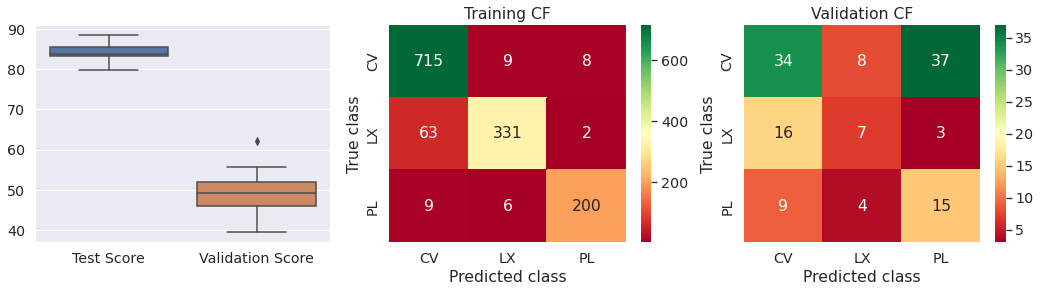

In [63]:
sns.set(font_scale=1.3)
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_val , clf.predict(x_val) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score

In [85]:
y_true , y_pred = y_val , clf.predict(x_val)


NameError: name 'precision_score' is not defined

In [89]:
y_pred_prob = clf.predict_proba(x_val)

In [88]:
from sklearn.metrics import precision_score , recall_score , roc_auc_score

In [100]:
ps = precision_score(y_true , y_pred , average=None)
rc = recall_score(y_true , y_pred , average=None)
auc = roc_auc_score(y_val_oh , y_pred_prob)
sc = pd.DataFrame(
    np.asarray([ps , rc]) , columns=['CV' , 'LX' , 'PL'] , index=['Precision' , 'Recall']
)
sc

ValueError: Expected array-like (array or non-string sequence), got OneHotEncoder(categories=obs_id
CV_49_obs_0      CV
CV_49_obs_1      CV
CV_49_obs_2      CV
CV_51_obs_0      CV
CV_53_obs_0      CV
CV_53_obs_1      CV
CV_56_obs_0      CV
CV_56_obs_1      CV
CV_60_obs_0      CV
CV_68_obs_0      CV
CV_76_obs_0      CV
CV_77_obs_0      CV
CV_78_obs_0      CV
CV_82_obs_0      CV
CV_86_obs_0      CV
LMXB_44_obs_0    LX
LMXB_62_obs_1    LX
LMXB_67_obs_1    LX
LMXB_71_obs_0    LX
LMXB_72_obs_0    LX
LMXB_75_obs_0    LX
LMXB_84_obs_0    LX
LMXB_85_obs_0    LX
LMXB_92_obs_0    LX
LMXB_94_obs_0    LX
PL_101_obs_0     PL
PL_102_obs_0     PL
PL_103_obs_0     PL
PL_106_obs_0     PL
PL_115_obs_0     PL
PL_118_obs_0     PL
PL_64_obs_0      PL
PL_73_obs_0      PL
PL_77_obs_0      PL
PL_79_obs_0      PL
PL_80_obs_0      PL
PL_85_obs_0      PL
PL_87_obs_0      PL
PL_88_obs_0      PL
PL_95_obs_0      PL
PL_99_obs_0      PL
Name: class, dtype: object)

In [391]:
pd.DataFrame({
    'feat' : x_train.columns.to_list() , 
    'val' : clf.feature_importances_
}).sort_values('val' , ascending=False).reset_index(drop=True)

,feat,val
0,photflux_aper_m,0.149696
1,var_inter_prob_m,0.135717
2,flux_aper_m,0.081213
3,var_inter_sigma_h,0.063748
4,var_inter_prob_s,0.054214
5,var_inter_index_h,0.043667
6,var_inter_sigma_m,0.042827
7,var_inter_sigma_b,0.036619
8,var_min_b,0.033070
9,var_inter_prob_b,0.032857
